# Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Load Preprocessed Data

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/total_data_guayas_region.csv')

# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Set the date column as the index
df.set_index('date', inplace=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/holidays_events.csv')

In [4]:
df.head()

,store_nbr,item_nbr,unit_sales,year,month,day,day_of_week,lag_1,lag_7,lag_14,rolling_avg_7,rolling_stdv_7
date,,,,,,,,,,,,
2013-01-16,24,105574,19.0,2013,1,16,2,3.0,7.0,12.0,5.857143,6.175990
2013-01-17,24,105574,7.0,2013,1,17,3,19.0,3.0,1.0,6.428571,6.051367
2013-01-18,24,105574,8.0,2013,1,18,4,7.0,6.0,3.0,6.714286,6.074929
2013-01-19,24,105574,5.0,2013,1,19,5,8.0,7.0,4.0,6.428571,6.106203
2013-01-20,24,105574,3.0,2013,1,20,6,5.0,1.0,7.0,6.714286,5.851333


# Filter for Store No. 24 & Item no. 105574

In [5]:
# Filter for a specific store and item
df_filtered = df[(df['store_nbr'] == 24) & (df['item_nbr'] == 105574)]

# Select relevant columns from df including additional features (e.g., 'year', 'month', 'day', etc.)
df_filtered = df_filtered[['unit_sales', 'lag_1', 'lag_7', 'rolling_avg_7', 'rolling_stdv_7',
                           'year', 'month', 'day', 'day_of_week']]

# Fill missing values using forward fill (ffill)
df_filtered.fillna(method='ffill', inplace=True)

# Display the first few rows
df_filtered.head()

<ipython-input-5-b2b77039d7db>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered.fillna(method='ffill', inplace=True)


,unit_sales,lag_1,lag_7,rolling_avg_7,rolling_stdv_7,year,month,day,day_of_week
date,,,,,,,,,
2013-01-16,19.0,3.0,7.0,5.857143,6.175990,2013,1,16,2
2013-01-17,7.0,19.0,3.0,6.428571,6.051367,2013,1,17,3
2013-01-18,8.0,7.0,6.0,6.714286,6.074929,2013,1,18,4
2013-01-19,5.0,8.0,7.0,6.428571,6.106203,2013,1,19,5
2013-01-20,3.0,5.0,1.0,6.714286,5.851333,2013,1,20,6


In [6]:
# Check for missing values in the dataset
df_filtered.isnull().sum()

,0
unit_sales,0
lag_1,0
lag_7,0
rolling_avg_7,0
rolling_stdv_7,0
year,0
month,0
day,0
day_of_week,0


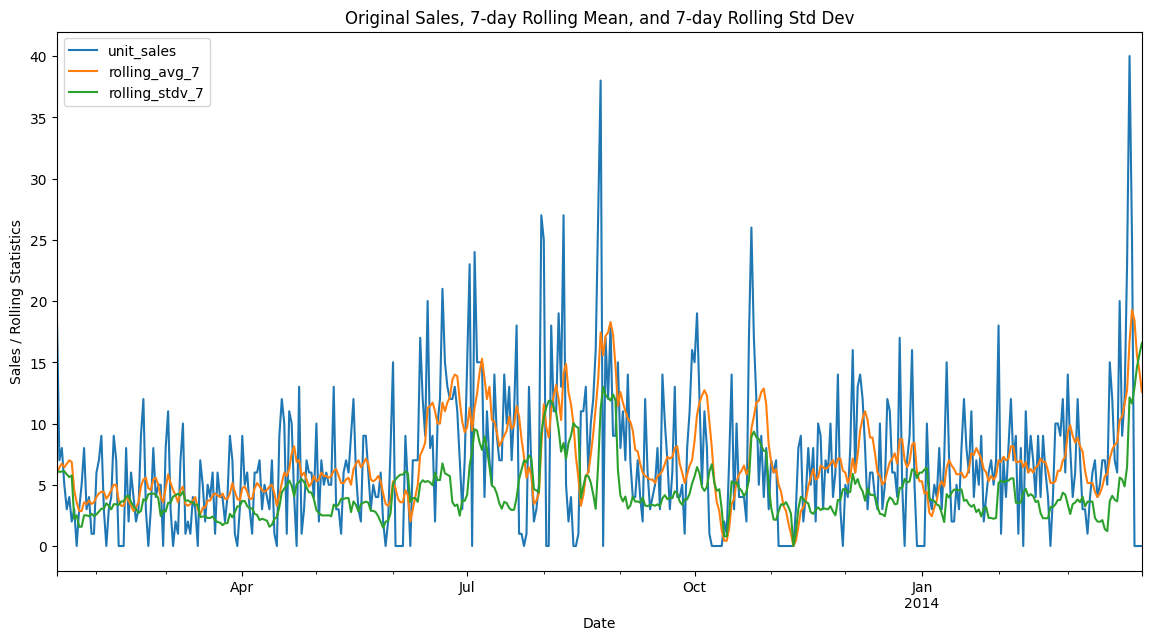

In [7]:
# Visualize the original sales alongside the new features
df_filtered[['unit_sales', 'rolling_avg_7', 'rolling_stdv_7']].plot(figsize=(14, 7))

# Add title and labels
plt.title('Original Sales, 7-day Rolling Mean, and 7-day Rolling Std Dev')
plt.xlabel('Date')
plt.ylabel('Sales / Rolling Statistics')

# Show the plot
plt.show()

# Data Preprocessing for LSTM Model: Feature Selection and Normalization

In [8]:
# Selecting relevant columns (input features and target variable)
X = df_filtered[['lag_1', 'lag_7', 'rolling_avg_7', 'rolling_stdv_7', 'year', 'month', 'day', 'day_of_week']].values
y = df_filtered['unit_sales'].values

# Normalize the feature values (LSTM models generally require data normalization)
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))  # Ensure y is in the right shape for scaling

# Check the shape of the scaled data
print(X_scaled.shape, y_scaled.shape)

(440, 8) (440, 1)


# Creating Sequences and Splitting Data for Time Series Forecasting

In [9]:
# Function to create sequences for time series data
def create_sequences(data, look_back):
    X_seq, y_seq = [], []
    for i in range(look_back, len(data)):
        X_seq.append(data[i-look_back:i, :])  # Previous 'look_back' time steps
        y_seq.append(data[i, 0])  # The current target (unit_sales)
    return np.array(X_seq), np.array(y_seq)

look_back = 7  # Define the number of previous days to look at for forecasting

# Prepare sequences
X_seq, y_seq = create_sequences(np.column_stack([X_scaled, y_scaled]), look_back)

# Split into training and testing data
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# Print shapes of the datasets
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(346, 7, 9) (346,)
(87, 7, 9) (87,)


# Building and Training an LSTM Model for Time Series Forecasting

In [10]:
# Build the LSTM model
model = Sequential()

# LSTM layer with 50 units and return_sequences=True for stacking LSTM layers
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# Dense layer to predict the target value
model.add(Dense(units=1))

# Compile the model with Mean Squared Error loss function and Adam optimizer
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=2, validation_data=(X_test, y_test))


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


346/346 - 3s - 9ms/step - loss: 0.0169 - val_loss: 0.0162
Epoch 2/20
346/346 - 1s - 4ms/step - loss: 0.0098 - val_loss: 0.0076
Epoch 3/20
346/346 - 1s - 3ms/step - loss: 0.0030 - val_loss: 0.0043
Epoch 4/20
346/346 - 1s - 4ms/step - loss: 3.8716e-04 - val_loss: 7.5349e-04
Epoch 5/20
346/346 - 1s - 3ms/step - loss: 2.3790e-04 - val_loss: 3.7264e-04
Epoch 6/20
346/346 - 2s - 5ms/step - loss: 1.3489e-04 - val_loss: 1.9850e-04
Epoch 7/20
346/346 - 3s - 8ms/step - loss: 8.9391e-05 - val_loss: 5.0143e-04
Epoch 8/20
346/346 - 2s - 6ms/step - loss: 1.1519e-04 - val_loss: 7.7600e-04
Epoch 9/20
346/346 - 1s - 4ms/step - loss: 1.0330e-04 - val_loss: 9.5817e-04
Epoch 10/20
346/346 - 1s - 3ms/step - loss: 1.0846e-04 - val_loss: 2.0700e-04
Epoch 11/20
346/346 - 1s - 4ms/step - loss: 7.3637e-05 - val_loss: 1.5768e-04
Epoch 12/20
346/346 - 1s - 4ms/step - loss: 8.2569e-05 - val_loss: 1.0368e-04
Epoch 13/20
346/346 - 1s - 4ms/step - loss: 1.1823e-04 - val_loss: 0.0011
Epoch 14/20
346/346 - 1s - 3ms/ste

# Evaluating the LSTM Model: Predictions vs Actual Sales with MSE and Plot

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Mean Squared Error (MSE): 0.43885196815508326


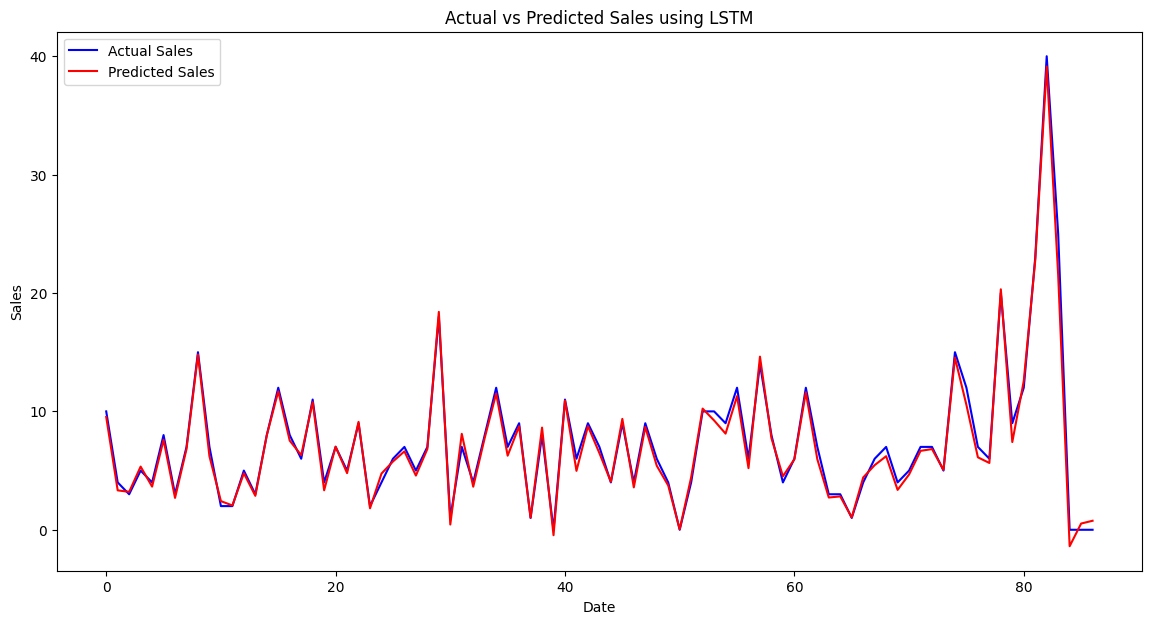

In [11]:
# Predicting on the test set
y_pred_scaled = model.predict(X_test)

# Inverse transform the scaled predictions and actual values back to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test_actual, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Plot the predicted vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual Sales', color='blue')
plt.plot(y_pred, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using LSTM')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()